# Load Data

This takes the labels.csv and loads it into a dataframe, sorting the breeds and ids to make it slightly easier to read.

In [6]:
#import the neccesary packages
import pandas as pd
import numpy as np

#constants
num_classes = 120 # the number of breeds we want to classify
seed = 42 # makes the random numbers in numpy predictable
im_size = 299 # This size of the images
batch_size = 32

#read the csv into a dataframe, group the breeds and append the path the to image in the `filename` column
df = pd.read_csv('labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)
df = df[df['breed'].isin(selected_breed_list)]
df['filename'] = df.apply(lambda x: ('train/' + x['id'] + '.jpg'), axis=1)


breeds = pd.Series(df['breed'])
print("total number of breeds to classify",len(breeds.unique()))

df.head()

total number of breeds to classify 120


,id,breed,filename
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [3]:
breeds.unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

# Image Prep

In order to make the images run smoothly through our model, some prep work needs to be done. The function below resizes an image to our desired size (299x299px). It also converts the image to a numpy array, which is much easier to work with in Python.

In [19]:
from keras.preprocessing import image

def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    path =  train_or_test + "/" + img_id + ".jpg"
    img = image.load_img(path, target_size=size)
    return image.img_to_array(img)

# Label Prep

In a similar vein as the function above, we need to convert the breed lables into vectors since our ML model can only deal with numbers.

We'll also split our data into training and testing sets for our model.

In [20]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
np.random.seed(seed=seed)
rnd = np.random.random(len(df))
train_idx = rnd < 0.9
valid_idx = rnd >= 0.9
y_train = label_enc.fit_transform(df["breed"].values)
ytr = y_train[train_idx]
yv = y_train[valid_idx]

# Model Building

Now we take the first steps with our actual model. The code below takes the data from our pandas dataframe and calls the read_img function. It uses the image id to pull from the /train folder and resizes each image to our desired size.

xception is a prebuilt model that helps give us a baseline so that we don't have to train our model from scratch. Our code's focus is builing upon that baseline and training it on dog breeds specifically.

## **Further Explanation Needed** Don't Forget George!

In [21]:
from tqdm import tqdm
from keras.applications import xception

x_train = np.zeros((train_idx.sum(), im_size, im_size, 3), dtype='float32')
x_valid = np.zeros((valid_idx.sum(), im_size, im_size, 3), dtype='float32')
train_i = 0
valid_i = 0
for i, img_id in tqdm(enumerate(df['id'])):
    img = read_img(img_id, 'train', (im_size, im_size))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    if train_idx[i]:
        x_train[train_i] = x
        train_i += 1
    elif valid_idx[i]:
        x_valid[valid_i] = x
        valid_i += 1
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

10222it [00:37, 273.28it/s]Train Images shape: (9242, 299, 299, 3) size: 2,478,732,126



In [27]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow(x_train, 
                                     ytr, 
                                     batch_size=batch_size)


valid_datagen = ImageDataGenerator()

valid_generator = valid_datagen.flow(x_valid, 
                                     yv, 
                                     batch_size=batch_size)

# Model

Below is the actual model

In [28]:

from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input

# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer and set it to the number of breeds we want to classifiy, 
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Training

First add some callback functions which run after each round of training. The training rounds are referred to as epochs.
- early_stopping -
- model_checkpoint -

## Optimizer

This is how the model "learns." An optimizer calculates the loss function, essentially the accuracy of the model compared to the test set. The goal is the make the loss value as low as possible.

keras has multiple optimizers, we found RMSprop to be the most consistent in or limited testing. It optimizes using gradient descent.


In [33]:
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
 
epochs = 10
learning_rate = 0.001
 
# checkpoints
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
STAMP = "{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d"))
 
bst_model_path = "{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
save_best_only=True,
save_weights_only=False,
verbose=1)
# compile the model
optimizer = RMSprop(lr=learning_rate, rho=0.9)
model.compile(optimizer=optimizer,
loss='sparse_categorical_crossentropy',
metrics=["accuracy"])
 
hist = model.fit(train_generator,
steps_per_epoch=train_idx.sum() // batch_size,
epochs=epochs, callbacks=[early_stopping, model_checkpoint],
validation_data=valid_generator,
validation_steps=valid_idx.sum() // batch_size)
 
model.save(bst_model_path)

Epoch 1/10
288/288 [==============================] - ETA: 0s - loss: 0.9749 - accuracy: 0.7670
Epoch 00001: val_loss improved from inf to 0.42260, saving model to 2020-07-15_dog_breed_model.h5
288/288 [==============================] - 666s 2s/step - loss: 0.9749 - accuracy: 0.7670 - val_loss: 0.4226 - val_accuracy: 0.8771
Epoch 2/10
288/288 [==============================] - ETA: 0s - loss: 0.9141 - accuracy: 0.7761
Epoch 00002: val_loss improved from 0.42260 to 0.40200, saving model to 2020-07-15_dog_breed_model.h5
288/288 [==============================] - 667s 2s/step - loss: 0.9141 - accuracy: 0.7761 - val_loss: 0.4020 - val_accuracy: 0.8781
Epoch 3/10
288/288 [==============================] - ETA: 0s - loss: 0.8262 - accuracy: 0.7838
Epoch 00003: val_loss did not improve from 0.40200
288/288 [==============================] - 669s 2s/step - loss: 0.8262 - accuracy: 0.7838 - val_loss: 0.4297 - val_accuracy: 0.8740
Epoch 4/10
288/288 [==============================] - ETA: 0s - l

# Testing Function

In [2]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def predict_from_image(img_path):

    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    
    pred = model.predict(img_tensor)
    sorted_breeds_list = sorted(selected_breed_list)
    predicted_class = sorted_breeds_list[np.argmax(pred)]
    
    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

    return predicted_class

# Sample Test

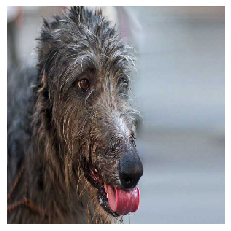

'scottish_deerhound'

In [6]:
from keras.models import load_model

model = load_model('2020-07-15_dog_breed_model.h5')
img_path = 'Scottish-Deerhound-2.jpg'    # dog
predict_from_image(img_path)

In [5]:
test_df = pd.read_csv('dog_df.csv')
test_df['filename'] = test_df.apply(lambda x: ('images/' + 'APA/' + x['id'] + '.jpg'), axis=1)
test_df

,id,breed,filename
0,2.02005E+13,Mixed_Breed_(Large),images/APA/2.02005E+13.jpg
1,2.01912E+13,Mixed_Breed_(Large),images/APA/2.01912E+13.jpg
2,2.01803E+13,Pit_Bull_Terrier,images/APA/2.01803E+13.jpg
3,2.02004E+13,Anatolian_Shepherd,images/APA/2.02004E+13.jpg
4,2.0181E+13,Labrador_Retriever,images/APA/2.0181E+13.jpg
...,...,...,...
189,2.02006E+13,Shepherd,images/APA/2.02006E+13.jpg
190,2.01811E+13,Labrador_Retriever,images/APA/2.01811E+13.jpg
191,2.02007E+13,Black_Labrador_Retriever,images/APA/2.02007E+13.jpg
192,2.02006E+13,Labrador_Retriever,images/APA/2.02006E+13.jpg


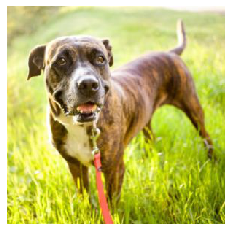

'boxer'

In [7]:
from keras.models import load_model

model = load_model('2020-07-15_dog_breed_model.h5')
img_path = 'images/APA/20161214223208 0.jpg'    # dog
predict_from_image(img_path)